In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
#import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *
from auto_encoder import *

#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor



from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)

transform = transforms.ToTensor()

kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
def fr50_Model(pretrained = False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #true works
    # create an anchor_generator for the FPN
    # which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        #sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        sizes=tuple([(10, 15, 20, 30, 40) for _ in range(5)]),
         
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    
    
    
    model.rpn.anchor_generator = anchor_generator

    # 256 because that's the number of features that FPN returns
    model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
    return model



#def faster_rcnn_model(pretrained = False):
    

In [2]:
def get_test_params(AE):
    if not next(AE.parameters()).is_cuda:
        AE.cuda()
        cpu = True
    else:
        cpu = False
    AE.eval()
    for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        if i == 0:
            continue
        samp_pan = sew_images_panorm(sample) #convert to panoramic tensor
        samp_pan_t = torch.stack(samp_pan, dim = 0).cuda() #stack
        images = AE.return_image_tensor(samp_pan_t).to('cuda') #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to('cuda') for k, v in t.items()} for t in targets]
        break
    if cpu:
        AE.cpu()
    return images,targets
        

def get_prediction(images):
    model.eval()
    with torch.no_grad():
         prediction = model(images.cuda())
    return prediction

def plot_prediction(prediction,targets):

    for index in range(len(predictions)):
        im = gen_result_chart(prediction[index])
        fig, axs = plt.subplots(1,2,figsize=(6, 3))
        #color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

        axs[0].imshow(im, cmap ='binary')

        #plot target

        road_img = gen_result_chart(targets [index])
        #fig, ax = plt.subplots(figsize = (2,3))
        #color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

        axs[1].imshow(road_img, cmap ='binary')

    
    


#check one sample from train with batch size 20
# for i, (sample, old_targets, road_image, extra) in enumerate(train_data_loader): #, print_freq, header): 
        
#         images = sample
#         targets = trans_target(old_targets)
#         #print("images len {}, targets len {}".format(len(images), len(targets)))
#         #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
#         #images = list(image.to(device) for image in images)
#         #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         break

# normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
#                                  std=[0.31936955, 0.3117349 , 0.2953726 ])

# tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) 

# #images = [tt(sew_images(s)) for s in sample] #list of [3, 800, 800], should be 1 per patch
# targets = trans_target(old_targets)

In [3]:
#now check the autoencoder
AE = get_autoencoder()
AE.cuda()

ConvAutoencoder(
  (enc_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (z): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (dec_conv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
  (dec_conv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

In [5]:
# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(False) #try False

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 200
train_encoder = False

for epoch in range(num_epochs):
    if epoch > 10:
        train_encoder = True
    if train_encoder:
        AE.cuda()
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100, 
                             mode = "autoencode", encoder = AE,train_encoder = train_encoder )
    # update the learning rate
    lr_scheduler.step()
    images,target = get_test_params(AE)
    predictions = get_prediction(images)
    plot_prediction(predictions,target)
    if epoch % 10 == 9:
        torch.save(model.state_dict(),f"bw_with_auto_{epoch}.pt")

Epoch: [0]  [  0/479]  eta: 0:15:46  lr: 0.000100  loss: 5.2709 (5.2709)  loss_classifier: 4.4972 (4.4972)  loss_box_reg: 0.0064 (0.0064)  loss_objectness: 0.6929 (0.6929)  loss_rpn_box_reg: 0.0744 (0.0744)  time: 1.9769  data: 0.6693  max mem: 3753


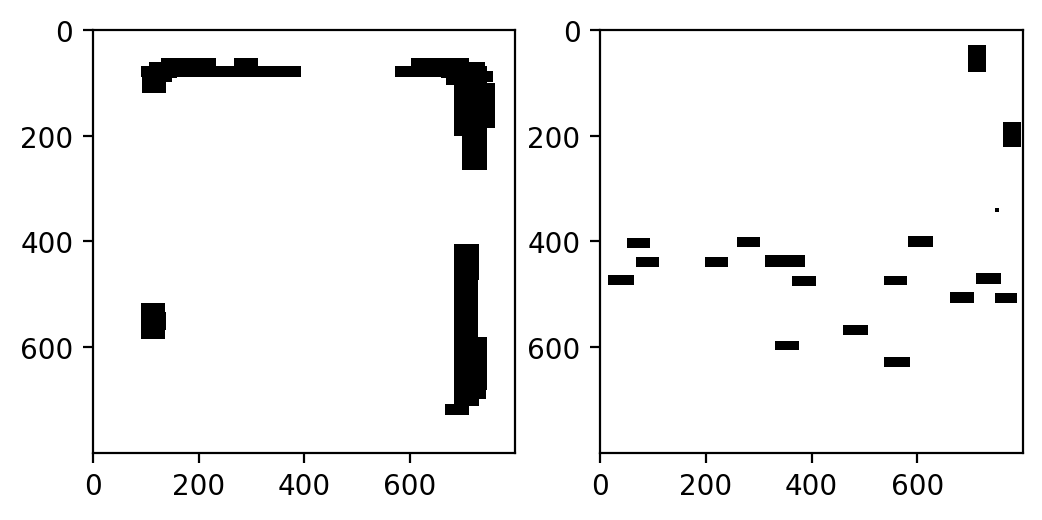

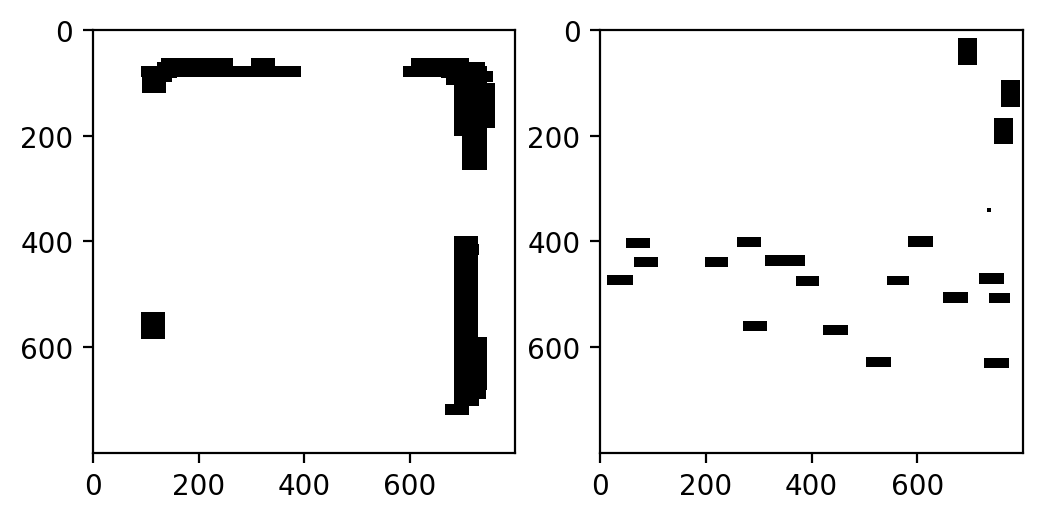

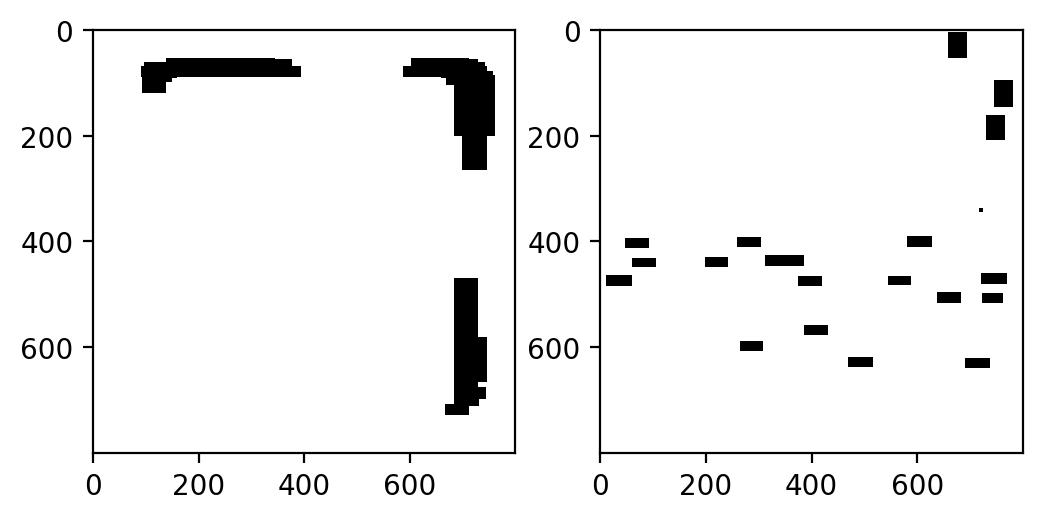

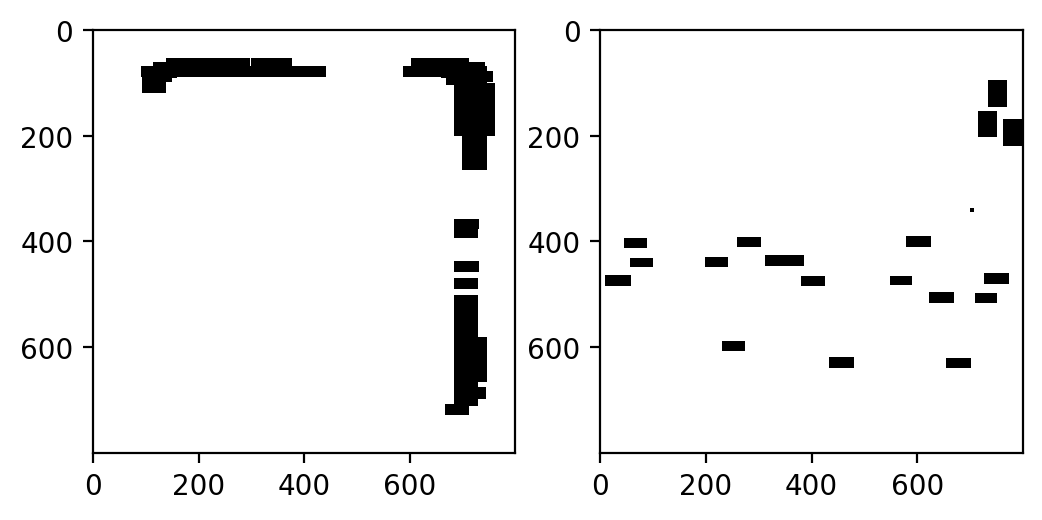

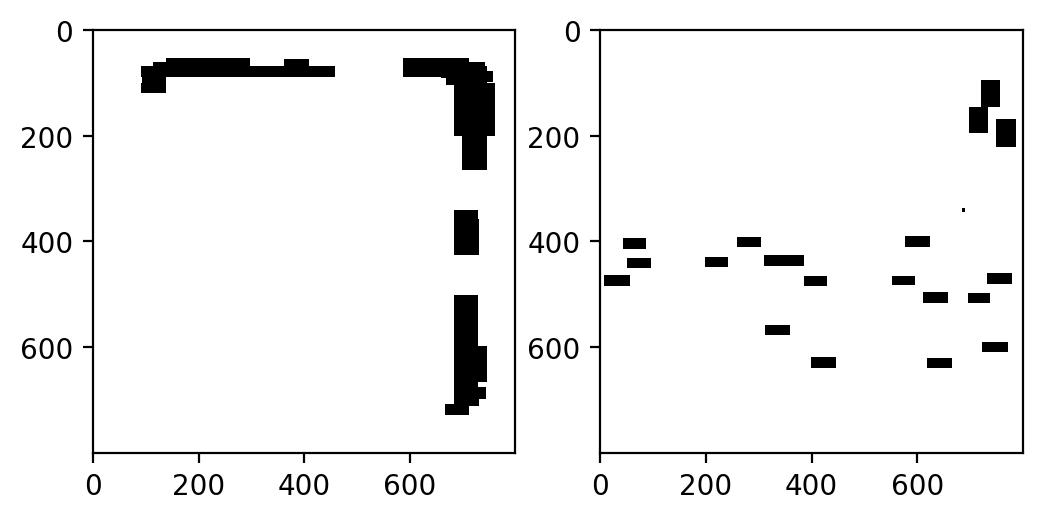

In [17]:
model = model = fr50_Model(False) 
model.load_state_dict(torch.load("bw_with_auto_9.pt"))
model.cuda()
images,target = get_test_params(AE)
predictions = get_prediction(images)
plot_prediction(predictions,target)

<bound method Module.cuda of ConvAutoencoder(
  (enc_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (z): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (dec_conv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
  (dec_conv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
)>

In [1]:
plot_image(i[0].detach().cpu())

NameError: name 'plot_image' is not defined

In [ ]:
torch.save(model.state_dict(),"temp.pt")

In [ ]:
%debug

In [ ]:
model = fr50_Model(False)

In [ ]:
model.load_state_dict(torch.load("temp.pt"))

In [ ]:
model.cuda()

In [ ]:
#Evaluate on 1 sample



In [ ]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        samp_pan = sew_images_panorm(sample) #convert to panoramic tensor
        samp_pan_t = torch.stack(samp_pan, dim = 0) #stack
        images = AE.return_image_tensor(samp_pan_t).to(device) #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if i ==1:
            break

In [ ]:
 model.eval()
with torch.no_grad():
     prediction2 = model(images)

In [ ]:
#plot prediction
 
road_img = gen_result_chart(prediction2[0])
fig, ax = plt.subplots(figsize=(2, 3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

In [ ]:
#plot target
 
road_img = gen_result_chart(targets [0])
fig, ax = plt.subplots(figsize = (2,3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

In [ ]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            
            }, "../models/fastRCNN_autoencode14epoch.pt")

In [2]:
to_img =  transforms.ToPILImage()
model.eval()
with torch.no_grad():
    for i ,(sample, target, road_image, extra) in  enumerate(val_data_loader):

        samp_pan = sew_images_panorm(sample) #convert to panoramic tensor
        samp_pan_t = torch.stack(samp_pan, dim = 0) #stack
        images = AE.return_image_tensor(samp_pan_t).to(device) #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        prediction_ = model(images)
    
        road_img = gen_result_chart(prediction_[0])
        
        sam_img = to_img(samp_pan[0])
        
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.imshow(sam_img)
        ax2.imshow(road_img, cmap ='binary')
        ax3.imshow(gen_result_chart(targets [0]), cmap='binary')
        
        if i == 4:
            break

NameError: name 'transforms' is not defined

In [ ]:
val_labeled_scene_index

In [ ]:
transform = transforms.ToTensor()
scene_132DS = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=np.array([132]),
                                  transform=transform,
                                  extra_info=True
                                 )
s132_loader = torch.utils.data.DataLoader(scene_132DS , batch_size=5, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
len(scene_132DS)

In [ ]:
for i ,(sample, target, road_image, extra) in  enumerate(s132_loader):
    print(len(sample))
    for b in sample:
        plt.imshow(torchvision.utils.make_grid(b, nrow=3).numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()
    